In [1]:
import os, statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from itertools import combinations
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

# T003 DigitalEnergy - Cycles Analysis
---

### Table of content:
* Data preparation
* Cycles detection
* Frequency conversion
* Clustering
* Cycles analysis & export
* Metrics

### Input

In [2]:
#SET BEFORE RUNNING:
#targets:
DATADIR = "../../datas"
EXP = "../exp"
ASSET_TYPE = "pv"   #common part of the various CSVs name
FOCUS_DEVICE = "DE_KN_industrial1_pv_1"   #focus device: file name without '.csv' (i.e. "DE_KN_industrial1_grid_import")

#control params:
DELTAT = 15   #Number of minutes after deactivation to mark the end of a Cycle
MAX_OUT_THRESHOLD = 5   #(Multiplier) Set to 0 to turn off. Max threshold for removal of outlier Cycles
MIN_LENGTH = 3   #Drop cycles shorter than MIN_LENGTH minutes
OUTLIERS_QMAX = 90   #Set to 0 to turn off. Max quantile for outlier values detection
SIGNIFICANCE = 0.03   #Set to 0 to turn off. Min % cutoff threshold for values

#for pairwise comparisons only:
MAX_CYCLES_FOR_COMBOS = 5000   #Set to 0 to turn off. Force reduce calculation of combinations over this chosen number of cycles if the calculations take too long.
MAX_PAIRS_NUM = 1000000   #Set to 0 to turn off. Force reduce pairwise comparisons over this chosen number of pairs if the calculations take too long.

### Data preparation

Preparation of a DataFrame with the data recorded for the selected FOCUS_DEVICE, cleaned from outliers & noise.

All data are converted to incremental values.

In [3]:
#function: outliers removal:
def remove_outliers(series, qmax=75, qmin=25):
    #get Q1 & Q3:
    series = np.array(series)
    qmax,qmin = np.percentile(series[series.nonzero()],[qmax,qmin])
    #print(qmax, qmin)
    #get IQR (interquartile range):
    intr_qr = qmax-qmin
    #get upper/lower bounds: 
    upper = qmax+(1.5*intr_qr) #qmax+(1.5*IQR)
    lower = qmin-(1.5*intr_qr) #qmin-(1.5*IQR)
    lower = 0 if lower < 0 else lower
    #replace in series
    series = np.where(series > upper, upper, series)
    #series = np.where(series < lower, lower, series)
    return series

In [4]:
#set names:
PLANT = "_".join(FOCUS_DEVICE.split('_')[0:3])
FOCUSNAME = f"{FOCUS_DEVICE.split('_')[2]}_{FOCUS_DEVICE.split('_')[-1] if FOCUS_DEVICE.split('_')[-1] != ASSET_TYPE.split('_')[-1] else 1}"   #name for CSV export (i.e. "industrial3_1.csv")

#get data:
Cycles = pd.read_csv(f"{DATADIR}/{PLANT}/{FOCUS_DEVICE}.csv")
Cycles['utc_timestamp'] = pd.to_datetime(Cycles['utc_timestamp'], format='%Y-%m-%d %H:%M')

#get incremental values:
Cycles[FOCUS_DEVICE] = Cycles[FOCUS_DEVICE].diff().fillna(0)
Cycles.rename(columns={"utc_timestamp": "timestamp", FOCUS_DEVICE: "value"}, inplace=True)

#remove outlier values (KWh):
if OUTLIERS_QMAX > 0:
    print(f"Max value pre-cleaning: {Cycles['value'].max()}")
    Cycles['value'] = remove_outliers(Cycles['value'], qmax=OUTLIERS_QMAX)
    print(f"Max value post-cleaning: {Cycles['value'].max()}")

#min value threshold (kWh):
if SIGNIFICANCE > 0:
    threshold = Cycles['value'].max()*SIGNIFICANCE
    print(f"Min significance threshold: {threshold}")
    Cycles['value'][Cycles['value'] < threshold] = 0

Cycles.head(10)

Max value pre-cleaning: 0.13400000000001455
Max value post-cleaning: 0.13400000000001455
Min significance threshold: 0.004020000000000436


,timestamp,value
0,2015-10-23 14:25:00,0.000
1,2015-10-23 14:26:00,0.000
2,2015-10-23 14:27:00,0.000
3,2015-10-23 14:28:00,0.007
4,2015-10-23 14:29:00,0.005
5,2015-10-23 14:30:00,0.005
6,2015-10-23 14:31:00,0.010
7,2015-10-23 14:32:00,0.005
8,2015-10-23 14:33:00,0.005
9,2015-10-23 14:34:00,0.008


---
## CYCLES DETECTION

Automatic detection of consumption cycles & activation/deactivation times.

Extract & filter ACTIVATION & DEACTIVATION periods:

In [5]:
acts = Cycles.copy()

#select only active periods:
acts = acts.loc[acts['value'] > 0]
print(len(acts))
acts['timestamp'] = pd.to_datetime(acts['timestamp'], format='%Y-%m-%d %H:%M')
acts.reset_index(inplace=True)
acts.rename(columns={'index': 'old_index'}, inplace=True)

#calculate delta time with previous and next values:
acts['deltas_before'] = acts['old_index'].diff(1).fillna(0)
acts['deltas_after'] = acts['old_index'].diff(-1).fillna(0)
acts['deltas_after'] = -acts['deltas_after']   #change sign

#mark cycle activation & deactivation only if the value is not isolated in time:
acts['is_activation'] = np.where(np.logical_and(acts['deltas_before'] >= DELTAT, acts['deltas_after'] <= DELTAT), 1, 0)
acts['is_deactivation'] = np.where(np.logical_and(acts['deltas_before'] <= DELTAT, acts['deltas_after'] >= DELTAT), 1, 0)

#turn off invalid values:
acts['is_activation'].iloc[0] = 0
acts['is_deactivation'].iloc[0] = 0
acts['is_activation'].iloc[-1] = 0
acts['is_deactivation'].iloc[-1] = 0

acts

353866


,old_index,timestamp,value,deltas_before,deltas_after,is_activation,is_deactivation
0,3,2015-10-23 14:28:00,0.007,0.0,1.0,0,0
1,4,2015-10-23 14:29:00,0.005,1.0,1.0,0,0
2,5,2015-10-23 14:30:00,0.005,1.0,1.0,0,0
3,6,2015-10-23 14:31:00,0.010,1.0,1.0,0,0
4,7,2015-10-23 14:32:00,0.005,1.0,1.0,0,0
...,...,...,...,...,...,...,...
353861,1036867,2017-10-12 15:32:00,0.005,3.0,3.0,0,0
353862,1036870,2017-10-12 15:35:00,0.006,3.0,9.0,0,0
353863,1036879,2017-10-12 15:44:00,0.005,9.0,15.0,0,1
353864,1036894,2017-10-12 15:59:00,0.005,15.0,9.0,1,0


Merge:

In [6]:
#merge filtered activations with Cycle dataframe:
Cycles = Cycles.merge(acts[['timestamp', 'is_activation', 'is_deactivation']], how='outer', on='timestamp')
del acts   #clean memory
Cycles.sort_values(by='timestamp', inplace=True)
Cycles['is_activation'] = Cycles['is_activation'].fillna(0)
Cycles['is_deactivation'] = Cycles['is_deactivation'].fillna(0)
Cycles.dropna(inplace=True)
Cycles.reset_index(drop=True, inplace=True)
Cycles.tail(10)

,timestamp,value,is_activation,is_deactivation
1037244,2017-10-12 21:49:00,0.0,0.0,0.0
1037245,2017-10-12 21:50:00,0.0,0.0,0.0
1037246,2017-10-12 21:51:00,0.0,0.0,0.0
1037247,2017-10-12 21:52:00,0.0,0.0,0.0
1037248,2017-10-12 21:53:00,0.0,0.0,0.0
1037249,2017-10-12 21:54:00,0.0,0.0,0.0
1037250,2017-10-12 21:55:00,0.0,0.0,0.0
1037251,2017-10-12 21:56:00,0.0,0.0,0.0
1037252,2017-10-12 21:57:00,0.0,0.0,0.0
1037253,2017-10-12 21:58:00,0.0,0.0,0.0


Add cycle info:

In [7]:
#init info columns:
cycle_no = []
start_times = []
end_times = []
on_off = []

start = np.NaN
end = np.NaN
time_from_act = 0
on = False
c = 0

for ind in Cycles.index:
    #when a new Cycle starts:
    if Cycles['is_activation'].iloc[ind] == 1:
        on = True
        c = c+1
        #update Cycle start details:
        time_from_act = 0
        start = pd.Timestamp(Cycles['timestamp'].iloc[ind])
    elif Cycles['is_deactivation'].iloc[ind] == 1 and on == True:
        on = False
        end = pd.Timestamp(Cycles['timestamp'].iloc[ind])
        #replace deact times in column:
        end_times[(-time_from_act-1):] = [end for i in range(time_from_act+1)]
        time_from_act += 1
    else:
        time_from_act += 1
    #for each row: store last Cycle start details:
    cycle_no.append(c)
    start_times.append(start)
    end_times.append(end)
    on_off.append(on)

Cycles['cycle_no'] = cycle_no
Cycles['on_off'] = on_off
Cycles['start_time'] = start_times
Cycles['end_time'] = end_times

Cycles.set_index('timestamp',drop=True,inplace=True)
Cycles.tail(10)

,value,is_activation,is_deactivation,cycle_no,on_off,start_time,end_time
timestamp,,,,,,,
2017-10-12 21:49:00,0.0,0.0,0.0,1043,True,2017-10-12 15:59:00,2017-10-12 15:44:00
2017-10-12 21:50:00,0.0,0.0,0.0,1043,True,2017-10-12 15:59:00,2017-10-12 15:44:00
2017-10-12 21:51:00,0.0,0.0,0.0,1043,True,2017-10-12 15:59:00,2017-10-12 15:44:00
2017-10-12 21:52:00,0.0,0.0,0.0,1043,True,2017-10-12 15:59:00,2017-10-12 15:44:00
2017-10-12 21:53:00,0.0,0.0,0.0,1043,True,2017-10-12 15:59:00,2017-10-12 15:44:00
2017-10-12 21:54:00,0.0,0.0,0.0,1043,True,2017-10-12 15:59:00,2017-10-12 15:44:00
2017-10-12 21:55:00,0.0,0.0,0.0,1043,True,2017-10-12 15:59:00,2017-10-12 15:44:00
2017-10-12 21:56:00,0.0,0.0,0.0,1043,True,2017-10-12 15:59:00,2017-10-12 15:44:00
2017-10-12 21:57:00,0.0,0.0,0.0,1043,True,2017-10-12 15:59:00,2017-10-12 15:44:00


Filter active periods:

In [8]:
#TIME SLICING:
ActCycles = Cycles.loc[Cycles['on_off'] == True]
ActCycles.drop(columns=['is_activation', 'is_deactivation'], inplace=True)
del Cycles   #clean memory
ActCycles.head()

,value,cycle_no,on_off,start_time,end_time
timestamp,,,,,
2015-10-24 06:46:00,0.005,1,True,2015-10-24 06:46:00,2015-10-24 15:31:00
2015-10-24 06:47:00,0.000,1,True,2015-10-24 06:46:00,2015-10-24 15:31:00
2015-10-24 06:48:00,0.000,1,True,2015-10-24 06:46:00,2015-10-24 15:31:00
2015-10-24 06:49:00,0.005,1,True,2015-10-24 06:46:00,2015-10-24 15:31:00
2015-10-24 06:50:00,0.000,1,True,2015-10-24 06:46:00,2015-10-24 15:31:00


Outliers removal:

In [9]:
# Use outliers = True if outlier removal mode, False if filtering mode:
def cycles_cleaner(ActCycles, multiplier, outliers=True):
    #1) Drop cycles according to consumption (kWh):
    if outliers == True and multiplier != 0:
        #drop outliers:
        Temp = ActCycles.groupby([ActCycles['cycle_no']]).max()
        glob_max = Temp['value'].mean()
        Temp = Temp.loc[Temp['value'] < (multiplier*glob_max)]
        Temp = Temp.loc[Temp['value'] > ((1/multiplier)*glob_max)]
    else:
        #get global_mean (kWh):
        Temp = ActCycles.groupby([ActCycles['cycle_no']]).mean()
        glob_mean = Temp['value'].mean()
        #drop cycles with max (kWh) < global_mean (kWh):
        Temp = ActCycles.groupby([ActCycles['cycle_no']]).max()
        Temp = Temp.loc[Temp['value'] > glob_mean]
    acc_1 = list(Temp.index)

    Temp = ActCycles.groupby([ActCycles['cycle_no']]).count()

    #2) Drop cycles shorter than X minutes:
    if outliers == True:
        Temp = Temp[Temp['value'] > MIN_LENGTH]
    #3) Drop cycles according to length (mins):
    if multiplier != 0:
        glob_length = Temp['value'].mean()
        Temp = Temp[(Temp['value'] > ((1/multiplier)*glob_length)) & (Temp['value'] < (multiplier*glob_length))]
    acc_2 = list(Temp.index)

    #get intersection of accepted cycles:
    accepted_cycles = [val for val in acc_1 if val in acc_2]
    return accepted_cycles

In [10]:
#before:
c_bef = len(ActCycles['cycle_no'].unique().tolist())

#after (outliers removal mode):
accepted_cycles = cycles_cleaner(ActCycles, multiplier=MAX_OUT_THRESHOLD, outliers=True)
ActCycles = ActCycles[ActCycles['cycle_no'].isin(accepted_cycles)]
c_aft = len(accepted_cycles)

print(f"Removed {c_bef - c_aft} abnormal cycles out of {c_bef}.")
print(f"Kept {c_aft} cycles.")

Removed 334 abnormal cycles out of 1043.
Kept 709 cycles.


Sample plots (time domain):

[1, 3, 5, 6, 8, 9, 10, 11, 12]


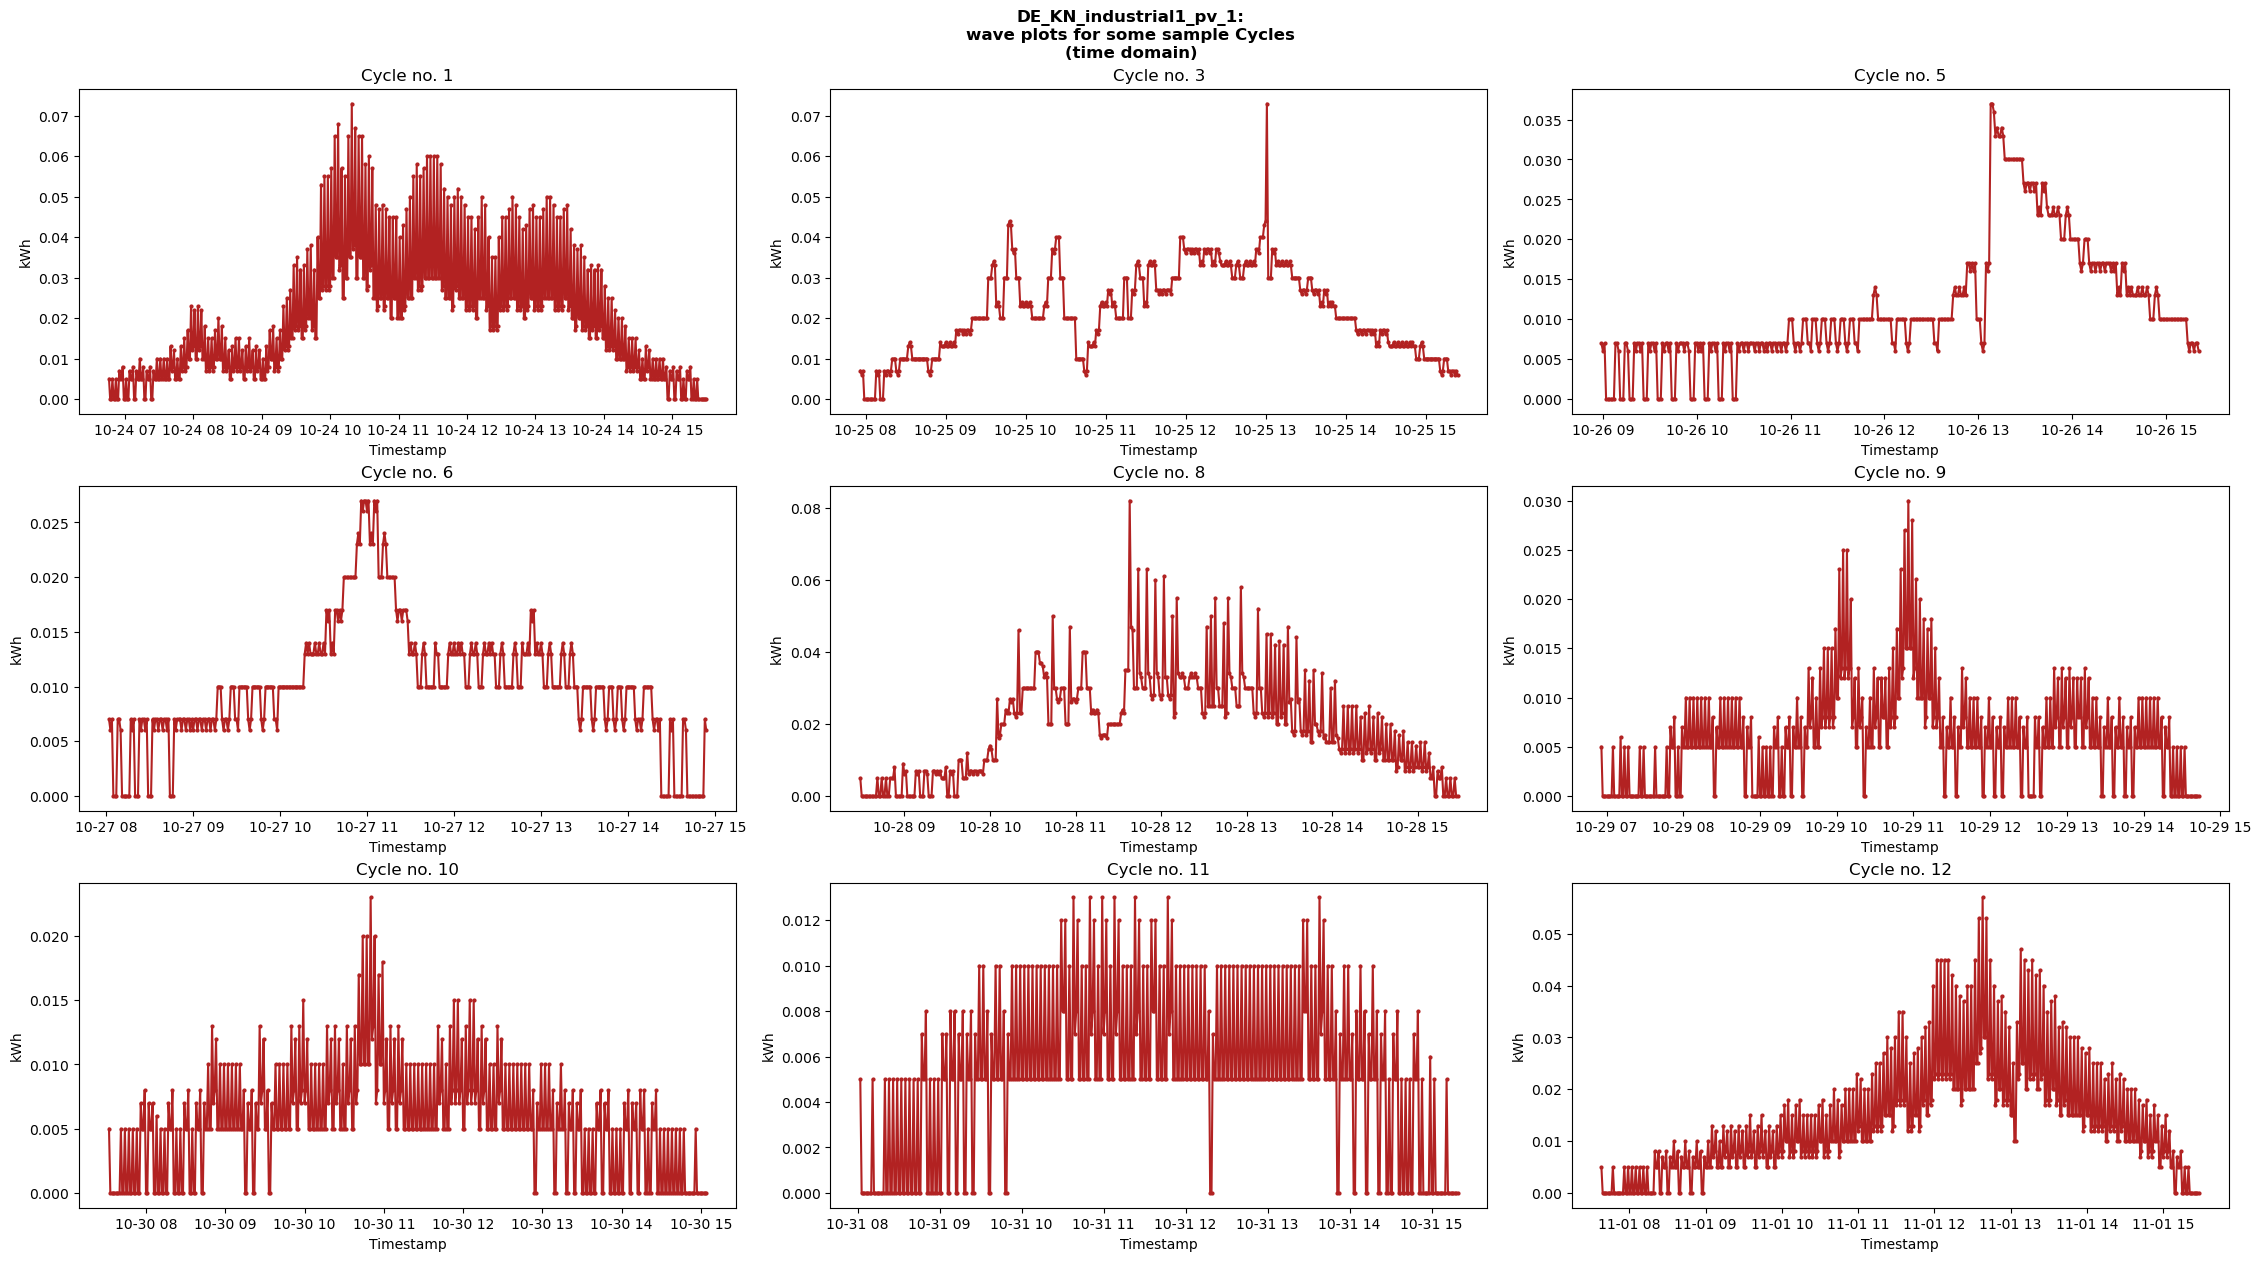

In [11]:
toplot = np.arange(1,10).tolist()

fig, subs = plt.subplots(3, 3, figsize=((720*3)/96, (400*3)/96), constrained_layout=True)
fig.suptitle(f"{FOCUS_DEVICE}:\nwave plots for some sample Cycles\n(time domain)", fontsize=12, fontweight='bold')
i = 0

cycles_toplot = ActCycles['cycle_no'].unique().tolist()[0:9]
print(cycles_toplot)

for row in range(3):
    for col in range(3):
        sub1 = subs[row, col]
        Temp = ActCycles.loc[ActCycles['cycle_no'] == cycles_toplot[i]]
        sub1.plot(Temp.index, Temp['value'], 'firebrick', linewidth=1.5, marker='o', markersize=2)
        sub1.set_title(f"Cycle no. {cycles_toplot[i]}")
        sub1.set_xlabel(f"Timestamp")
        sub1.set_ylabel("kWh")
        #set time format and the interval of ticks (every 30 minutes):
        if len(Temp.index) <= 300:
            labels = [ts for ts in Temp.index[::5]]
            sub1.set_xticks(labels)
            sub1.set_xticklabels(labels, rotation=45, ha='right')
            sub1.grid(axis="x",linestyle="--")
            xformatter = md.DateFormatter('%Y-%m-%d %H:%M')
            sub1.xaxis.set_major_formatter(xformatter)
        i += 1

plt.show()

---

## FREQUENCY CONVERSION

In [12]:
#function: get & plot frequencies:
def get_freqs(dataseries):
    #remove mean (zero frequency):
    x = dataseries.copy()
    x -= np.mean(x)

    #set FFT:
    T = 60
    Fs = 1/T
    L = len(x)

    #get FFT:
    f_FFT = np.fft.fft(x)

    # Amplitude normalization:
    # You need to scale it by dividing the fft result by the length of the time-domain signal
    P2 = abs(f_FFT/L)
    f_FFT_one_side = P2[:int((L/2)+1)]

    # you are using the two-sided Fourier transform, so the signal intensity will be equally divided between 
    # the negative frequencies and positive frequencies. In a one-sided Fourier transform, 
    # correct for this by multiplying the fft output by 2 to reproduce the amplitude of the original signals.
    f_FFT_one_side[2:-1] = 2 * f_FFT_one_side[2:-1]

    # Frequency normalization:
    n = np.arange(L)
    tf = L/Fs
    freq = n/tf

    #frequencies:
    f =  freq[:int((L/2)+1)]

    return f_FFT_one_side, f

Convert ActCycles into frequency domain:

In [13]:
to_merge = []
for cycle in accepted_cycles:
    print(f"Current: {cycle}", end="                 \r")
    #filter & get FFT:
    Filt = ActCycles[ActCycles['cycle_no'] == cycle]
    yf, xf = get_freqs(Filt['value'])
    #store df for later merge:
    Temp = pd.DataFrame({'xf': [round(fr, 5) for fr in xf], cycle: yf})
    to_merge.append(Temp.groupby([Temp['xf']]).sum())

#merge & sort:
FreqCycles = pd.DataFrame().join(to_merge, how="outer").fillna(0)
FreqCycles.sort_values(by='xf', inplace=True)
print(f"\nNo. of freqs: {len(FreqCycles.index)}")
FreqCycles.head(5)

Current: 1042                 
No. of freqs: 833


,1,3,5,6,8,9,10,11,12,14,...,1030,1031,1032,1034,1037,1038,1039,1040,1041,1042
xf,,,,,,,,,,,,,,,,,,,,,
0.00000,1.969324e-18,6.916144e-19,3.240906e-19,2.016144e-19,1.024313e-18,0.000000,1.894688e-19,4.118978e-19,1.630250e-19,3.658260e-19,...,1.178303e-18,6.205515e-19,3.426614e-18,1.783856e-19,3.422244e-19,2.511219e-19,1.574784e-18,2.234637e-18,1.349921e-18,7.709882e-19
0.00002,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.00003,8.406645e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.154117e-02,5.870057e-03,1.268126e-02,1.762520e-03,1.029028e-02,6.118051e-03,7.788886e-03,9.553875e-03,1.110421e-02,9.642087e-03
0.00004,0.000000e+00,5.806558e-03,4.321977e-03,3.177013e-03,7.799777e-03,0.001753,1.846432e-03,1.440448e-03,5.962057e-03,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.00005,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,7.237487e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


Sample plots (freq domain):

[1, 3, 5, 6, 8, 9, 10, 11, 12]


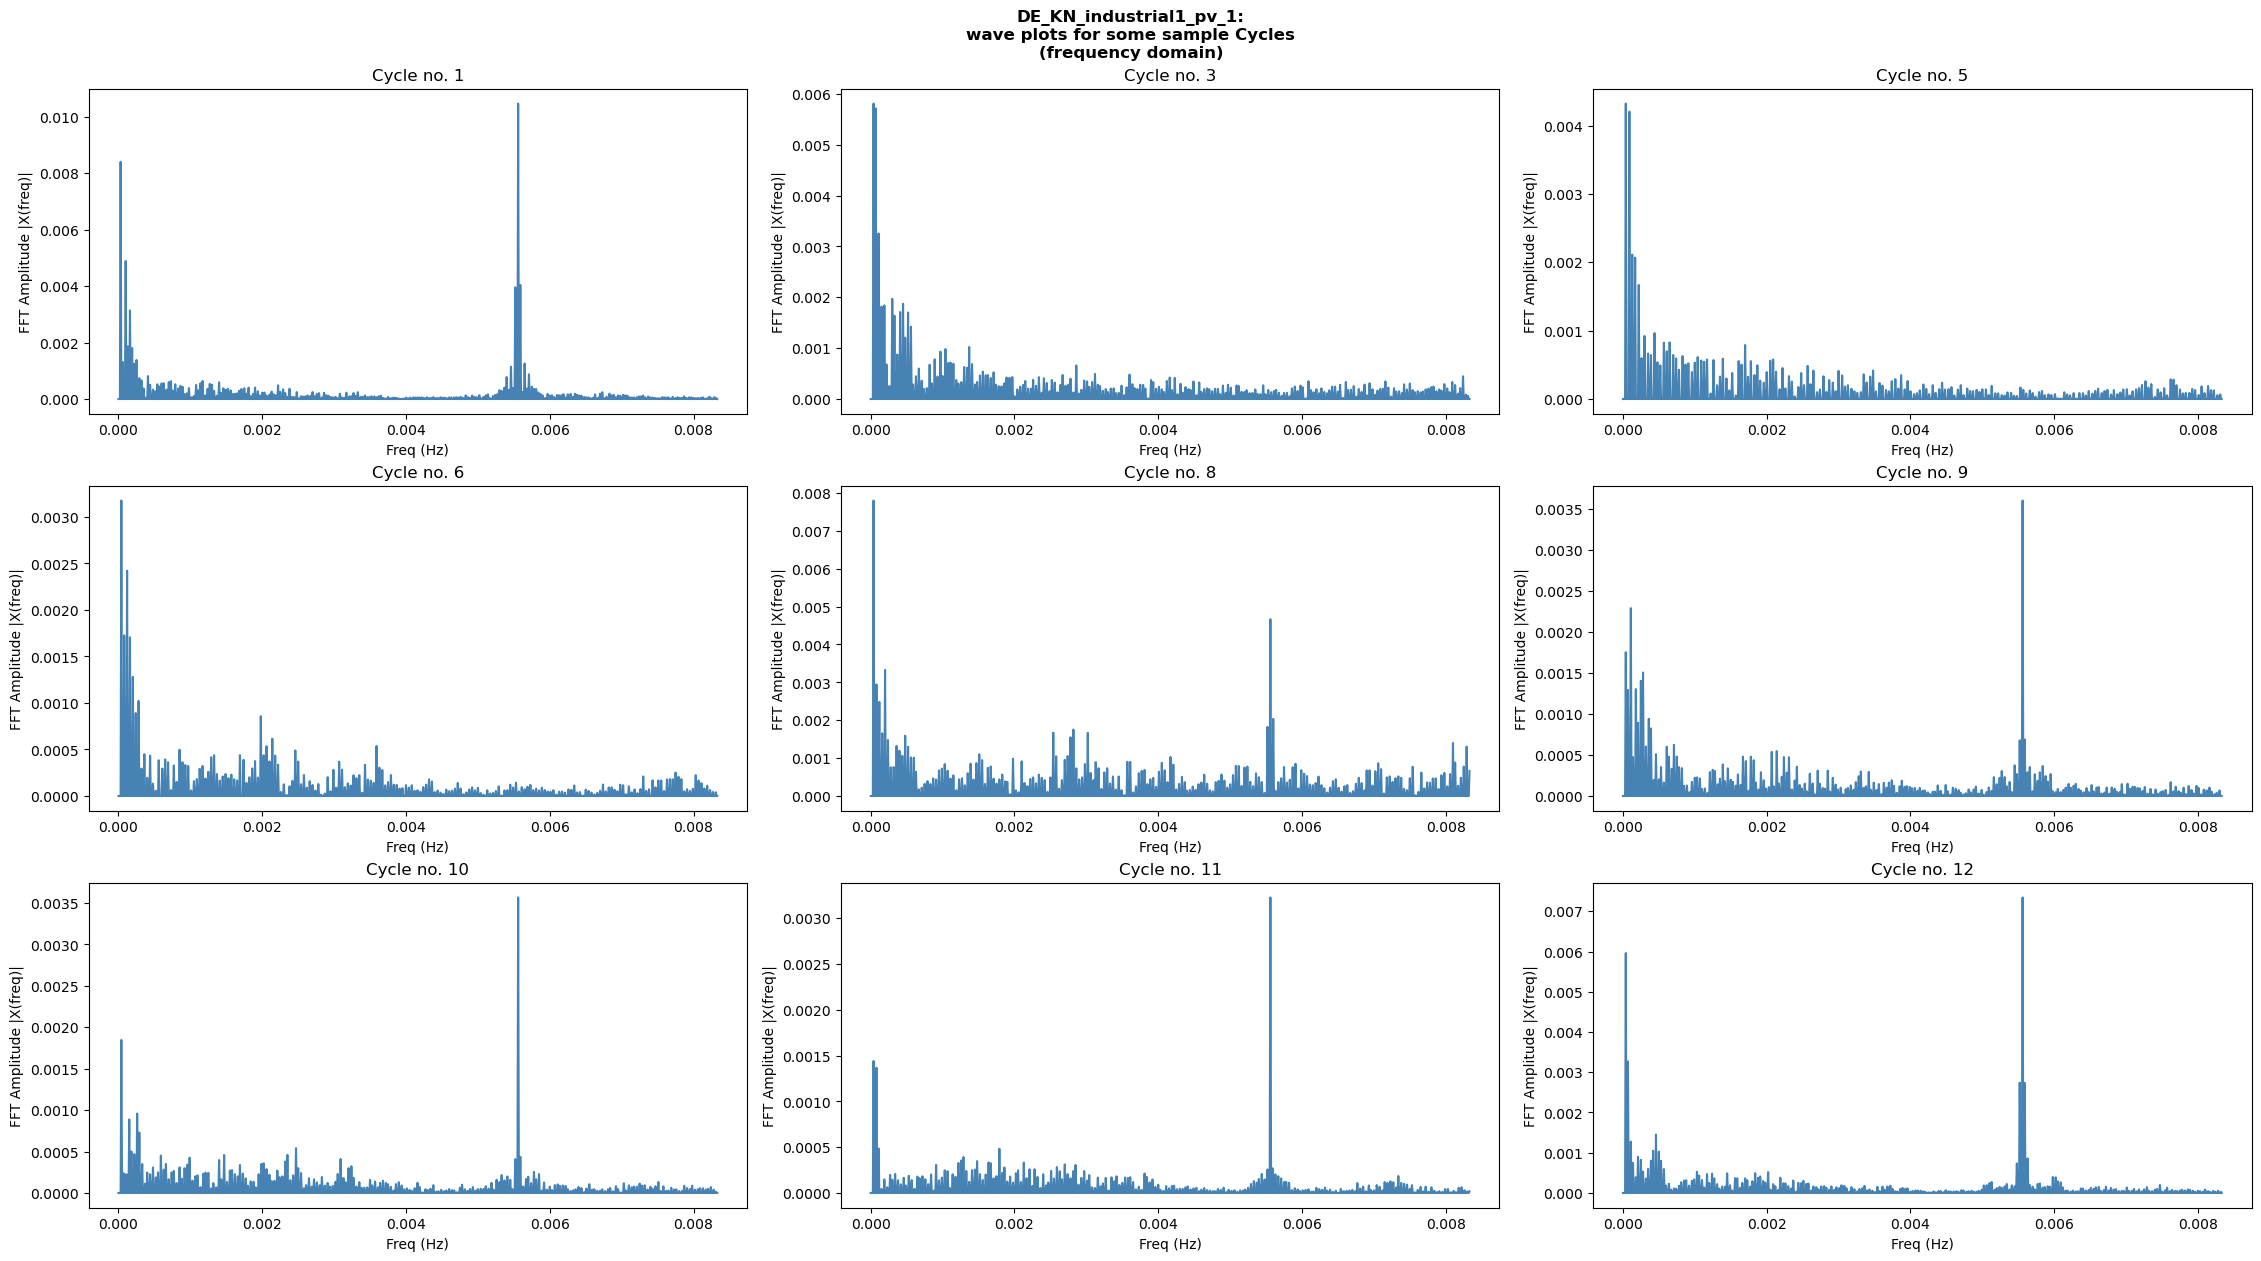

In [14]:
toplot = np.arange(1,10).tolist()

fig, subs = plt.subplots(3, 3, figsize=((720*3)/96, (400*3)/96), constrained_layout=True)
fig.suptitle(f"{FOCUS_DEVICE}:\nwave plots for some sample Cycles\n(frequency domain)", fontsize=12, fontweight='bold')
cycles_toplot = ActCycles['cycle_no'].unique().tolist()[0:9]
print(cycles_toplot)

i = 0

for row in range(3):
    for col in range(3):
        sub1 = subs[row, col]
        sub1.plot(FreqCycles.index, FreqCycles[cycles_toplot[i]], 'steelblue', linewidth=1.5)
        sub1.set_title(f"Cycle no. {cycles_toplot[i]}")
        sub1.set_xlabel(f"Freq (Hz)")
        sub1.set_ylabel("FFT Amplitude |X(freq)|")
        i += 1

plt.show()

---

## CLUSTERING

### Dimensionality reduction:

Aggregate frequencies by windows:

In [15]:
FreqWindows = FreqCycles.copy().fillna(0)
FreqWindows['xf_1'] = [round(fr, 3) for fr in FreqCycles.index]
FreqWindows = FreqWindows.groupby([FreqWindows['xf_1']]).sum()
FreqWindows.rename(columns={'xf_1': 'xf'}, inplace=True)

FreqWindows.head(20)

,1,3,5,6,8,9,10,11,12,14,...,1030,1031,1032,1034,1037,1038,1039,1040,1041,1042
xf_1,,,,,,,,,,,,,,,,,,,,,
0.000,0.027521,0.028639,0.018708,0.013733,0.026379,0.013986,0.007095,0.004574,0.018143,0.010124,...,0.067829,0.036382,0.034746,0.037987,0.036985,0.024659,0.047493,0.049299,0.024787,0.051969
0.001,0.012415,0.016503,0.011592,0.006720,0.014299,0.007446,0.006474,0.005182,0.009312,0.005316,...,0.035393,0.015825,0.011059,0.023220,0.052253,0.019775,0.030555,0.029458,0.010970,0.031724
0.002,0.007386,0.008849,0.008384,0.007335,0.012085,0.007375,0.006420,0.005240,0.007168,0.004981,...,0.016599,0.008544,0.007179,0.009880,0.020174,0.008158,0.011713,0.013347,0.006385,0.013948
0.003,0.003739,0.007333,0.005572,0.004124,0.019191,0.004057,0.004184,0.004334,0.003656,0.003003,...,0.011917,0.004051,0.004866,0.003866,0.011316,0.004418,0.006568,0.007264,0.003828,0.007276
0.004,0.001595,0.006579,0.003895,0.003495,0.011926,0.002675,0.002097,0.002370,0.002015,0.001997,...,0.007742,0.002200,0.002049,0.003147,0.003193,0.002511,0.002639,0.002858,0.001752,0.002976
0.005,0.005685,0.004709,0.002486,0.001532,0.010361,0.003189,0.002052,0.001501,0.003564,0.004536,...,0.017062,0.008511,0.005760,0.010061,0.011191,0.006334,0.011585,0.011539,0.004295,0.012956
0.006,0.025194,0.004491,0.001779,0.001641,0.017723,0.008736,0.006673,0.005209,0.017313,0.007296,...,0.046493,0.027815,0.037632,0.020854,0.038916,0.020590,0.032465,0.036950,0.031614,0.037926
0.007,0.002978,0.005185,0.002924,0.001847,0.009974,0.002177,0.001627,0.001797,0.002566,0.001424,...,0.008830,0.003182,0.002562,0.004457,0.009383,0.004124,0.005821,0.005651,0.002237,0.005900
0.008,0.001261,0.004285,0.002570,0.002692,0.011299,0.001599,0.001182,0.000724,0.001335,0.001679,...,0.006181,0.001976,0.001451,0.002037,0.002265,0.001287,0.001920,0.002094,0.002027,0.001988


Normalize FreqWindows:

In [16]:
#normalize:
scaler = StandardScaler()
FreqWindowsStd = scaler.fit_transform(FreqWindows.fillna(0).transpose().values)

#### Input

In [17]:
#PCA - Control parameters:
PCA_TGT_EVRATIO = 80   #Target % of explained variance for PCA best n_feats selection
N_MAX_FEATS = 5   #Max no. of PCA feats

#### PCA

Study PCA to reduce dimensionality and improve clustering:

In [18]:
#study the best n_feats for PCA:
pca = PCA()
pca.fit(FreqWindowsStd)
expl = list(pca.explained_variance_ratio_.cumsum())
print(expl)

#select best:
n_feats = 2
for i in range(2, len(expl)+2):
    if expl[i-2] > (PCA_TGT_EVRATIO/100):
        n_feats = i
        break

#upper limit:
if n_feats > N_MAX_FEATS:
    n_feats = N_MAX_FEATS

print(f"Optimal n of PCA features: {n_feats}")

[0.6906982760112265, 0.8825391534217633, 0.933001521516213, 0.9663932667615129, 0.9780611129146336, 0.9857018632372342, 0.9924424521701913, 0.9972371579806548, 0.9999999999999997]
Optimal n of PCA features: 3


Apply PCA with the selected n_feats:

In [19]:
pca = PCA(n_feats)
X = pca.fit_transform(FreqWindowsStd)
X.shape

(709, 3)

### Silhouette Score analysis:

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

The following conditions should be checked to select the optimal ‘K’ using the Silhouette plots:

1) For a particular K, all the clusters should have a Silhouette score more than the average score of the dataset (represented by a red dotted line).
2) There should not be wide fluctuations in the size of the clusters (along the x axis), meaning that the clusters must have approximately uniform lengths. The x-axis represents the Silhouette score.
3) There should not be wide fluctuations in the thickness of the clusters (along the y axis), meaning that the clusters must have approximately uniform widths. The width of the clusters represents the number of data points.
4) Low impact of datapoints with negative Silhouette score (i.e. of doubtful assignment) for the clusters.
5) Silhouette score must be the highest in which these conditions are verified.
6) Furthermore, in this implementation, a penalty is added for over-clustering.

Requirement #1 can be enabled/disabled through the global var *ACCEPT_ALL_CLUSTERS*, while the overall **Scoring Function** to balance requirements #2-6 is:

$$ KScore_k = α * AvgSil_k - β * StdevX_k - γ * StdevY_k + δ * Σ(Negs_k) - ε * Penalty_k $$

#### Input

In [20]:
#KSCORE - CONTROL PARAMETERS:
N_MAX_CLUSTERS = 7   #Max no. of clusters for Silhouette analysis
START_K_FOR_PENALTY = 4   #Starting K for penalty application
CLUST_PENALTY = 0.03   #Penalty for over-clustering
ACCEPT_ALL_CLUSTERS = True   #If False: only accept Ks where every cluster is above the average Sil score. If True: accept all Ks anyway.

ALPHA = 1   #weight of avg silhouette value
BETA = 0.5   #weight of StdevX
GAMMA = 0.5   #weight of StdevY
DELTA = 1   #weight of impact of Negatives
EPSILON = 1   #weight of penalty for overclustering

#### Analysis

For n_clusters = 2: the average silhouette_score is 0.5448050829782467
For n_clusters = 3: the average silhouette_score is 0.5437391379814212
For n_clusters = 4: the average silhouette_score is 0.4378532001945029
For n_clusters = 5: the average silhouette_score is 0.4414974933488665
For n_clusters = 6: the average silhouette_score is 0.4009618233552498
For n_clusters = 7: the average silhouette_score is 0.35905394822062914

Sum of negative scores: {2: -0.35994364743927926, 3: -0.15542481050252935, 4: -0.34429863752546463, 5: -0.2600243920102616, 6: -0.41462833768680357, 7: -0.49996929739613405}
Stdevs: {2: 0.3518673005411862, 3: 0.4056628706216748, 4: 0.2360973481332556, 5: 0.22924209526342892, 6: 0.16728482605732517, 7: 0.17052519323639737}

RANKING: {3: 0.18548289216805444, 5: 0.0368520537068904, 2: 0.0089277852683744, 4: -0.024494111397589502, 6: -0.1573089273602163, 7: -0.3161779457937036}
OPTIMAL K: 3


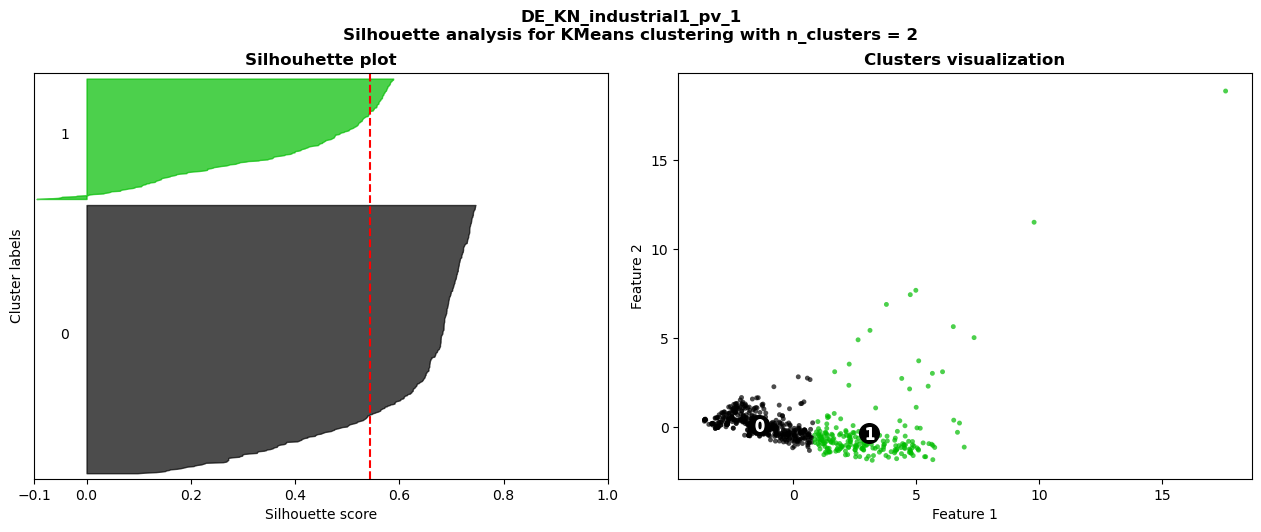

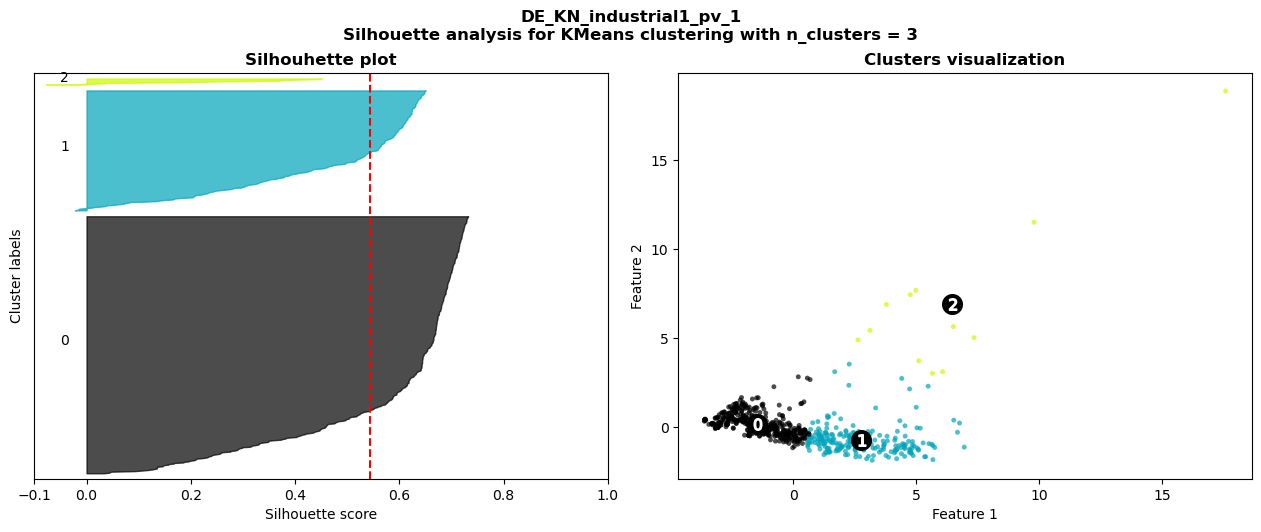

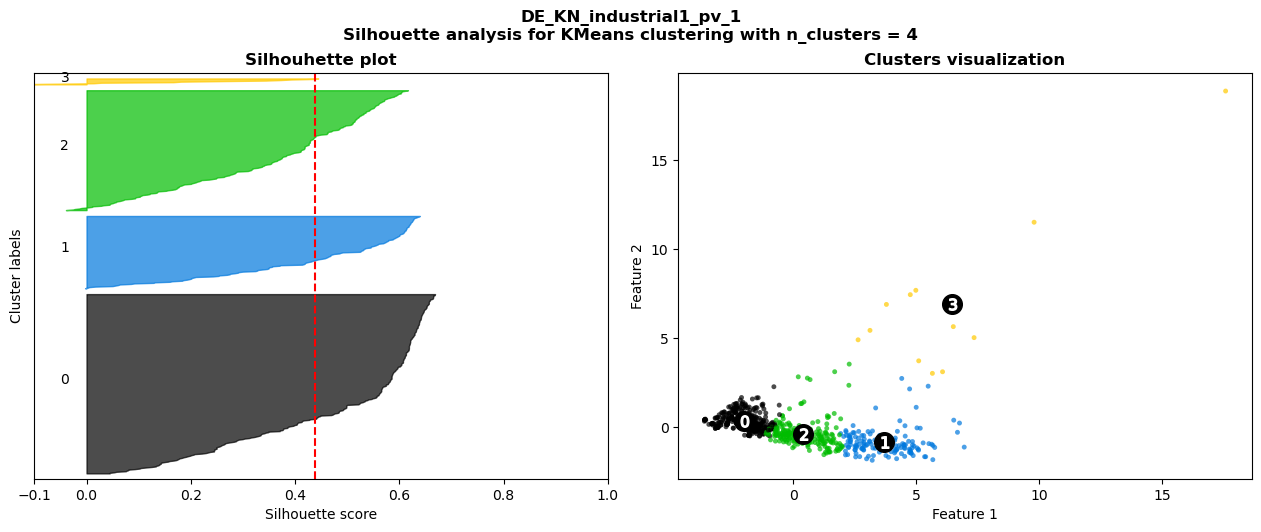

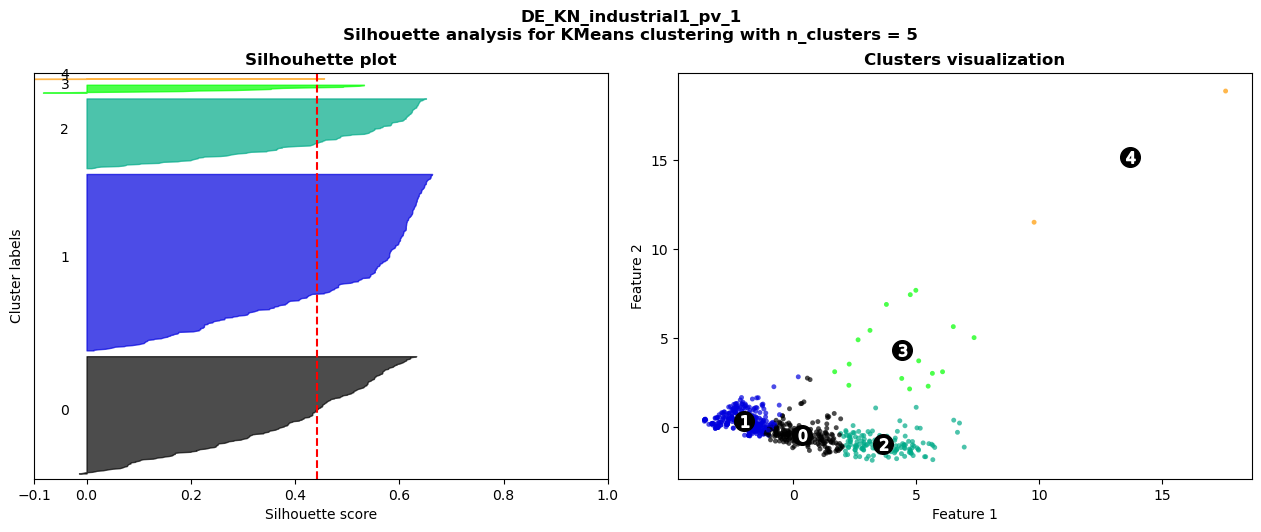

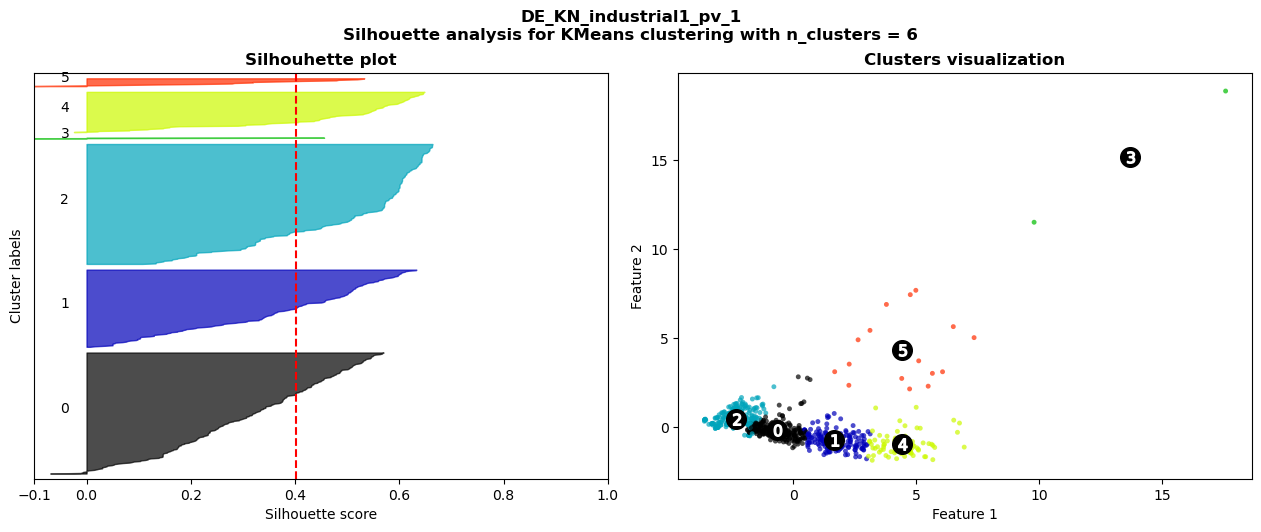

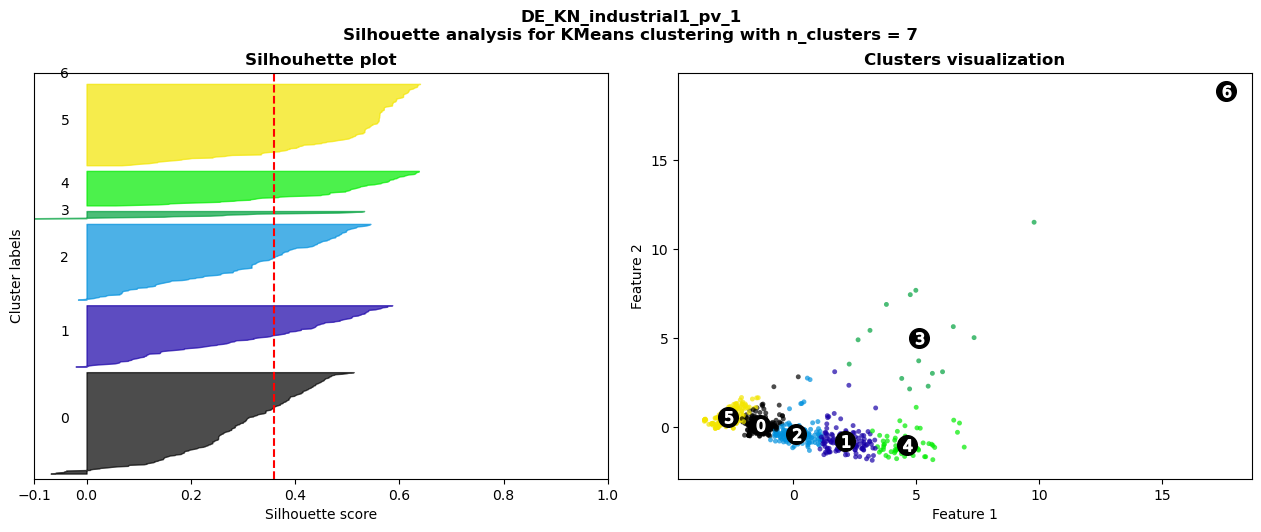

In [21]:
#init:
avg_sils = {}
neg_sils = {}
stdevs = {}
kscore_accepted = {}
kscore_backup = {}
penalty = 0

#FOR EVERY K:
for n_clusters in range(2, N_MAX_CLUSTERS+1):
    acceptable = True
    neg_sils[n_clusters] = []
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=((600*2)/96, 500/96), constrained_layout=True)
    plt.suptitle(f"{FOCUS_DEVICE}\nSilhouette analysis for KMeans clustering with n_clusters = {n_clusters}", fontsize=12, fontweight="bold")


    #1) SILHOUETTE PLOT:
    #the silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]:
    ax1.set_xlim([-0.1, 1])
    #the (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly:
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    #Initialize the clusterer with n_clusters value:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    #The silhouette_score gives the average value for all the samples. This gives a perspective into the density and separation of the formed clusters:
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}: the average silhouette_score is {silhouette_avg}")

    #compute the silhouette scores for each sample:
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    widths = []
    sils = []

    for i in range(n_clusters):
        #aggregate the silhouette scores for samples belonging to cluster i, and sort them:
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        widths.append(size_cluster_i)
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        #label the silhouette plots with their cluster numbers at the middle:
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        #compute the new y_lower for next plot:
        y_lower = y_upper + 10    # 10 for the 0 samples

        sils.append(max(ith_cluster_silhouette_values))

    ax1.set_title("Silhouhette plot", fontweight='bold')
    ax1.set_xlabel("Silhouette score")
    ax1.set_ylabel("Cluster labels")

    #the vertical line for average silhouette score of all the values:
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])    #clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    #2) CLUSTERS PLOT:
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=50, lw=0, alpha=0.7, c=colors
    )

    #labeling the clusters:
    centers = clusterer.cluster_centers_
    #draw white circles at cluster centers:
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="black",
        alpha=1,
        s=200
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], c='white', marker="$%d$" % i, alpha=1, s=70)

    ax2.set_title("Clusters visualization", fontweight='bold')
    ax2.set_xlabel("Feature 1")
    ax2.set_ylabel("Feature 2")


    #STORE DATA FOR OPTIMAL K SELECTION:
    avg_sils[n_clusters] = silhouette_avg
    #1) REQ #1: if enabled, check if every cluster has a max silhouette score > avg for the clusters (requirement #1):
    if ACCEPT_ALL_CLUSTERS == False:
        for sil in sils:
            #if not: mark the current k as not acceptable:
            if sil < silhouette_avg:
                print(f"K = {n_clusters} not acceptable.")
                acceptable = False
                break
    
    #2) store all negative Silhouette scores encountered tn the current clusters:
    for point_sil in sample_silhouette_values:
        if point_sil < 0:
            neg_sils[n_clusters].append(point_sil)
    
    #3) calculate SCORING FUNCTION:
    deltas_x = [i / sum(sils) for i in sils]   #size deltas in %
    deltas_y = [i / sum(widths) for i in widths]   #thickness deltas in %
    stdevx = statistics.stdev(deltas_x)
    stdevy = statistics.stdev(deltas_y)
    stdevs[n_clusters] = stdevx + stdevy

    #KSCORE: balance requirements #2-6:
    kscore = ALPHA * silhouette_avg - BETA * stdevx - GAMMA * stdevy + DELTA * sum(neg_sils[n_clusters]) - EPSILON * penalty
    kscore_backup[n_clusters] = kscore
    
    #if the current k is still acceptable: use in final ranking:
    if acceptable == True:
        kscore_accepted[n_clusters] = kscore
    
    #increase penalty for over-clustering:
    if n_clusters >= START_K_FOR_PENALTY:
        penalty += CLUST_PENALTY


#FINALLY: SELECT THE OPTIMAL K:
negs = {k: sum(v) for k,v in neg_sils.items()}
print(f"\nSum of negative scores: {negs}")
print(f"Stdevs: {stdevs}")
#get K related to the best value of the kscore function:
if kscore_accepted != {}:
    ranking = dict(sorted(kscore_accepted.items(), key=lambda item: item[1], reverse=True))
    print(f"\nRANKING: {ranking}")
    K = list(ranking.keys())[0]
else:
    print(f"\nAll Ks have clusters below the average sil_score. Ignoring requirement #1.")
    ranking = dict(sorted(kscore_backup.items(), key=lambda item: item[1], reverse=True))
    print(f"RANKING: {ranking}")
    K = list(ranking.keys())[0]
print(f"OPTIMAL K: {K}")
plt.show()

#### Cluster

Apply KMeans using the optimal number of clusters K:

In [22]:
#Initialize the class object
clusterer = KMeans(n_clusters=K, random_state=10)
labels = clusterer.fit_predict(X)

closest, _ = pairwise_distances_argmin_min(clusterer.cluster_centers_, X)
print(closest)

[438 671 491]


Plot clusters centroids (time & freq domain):

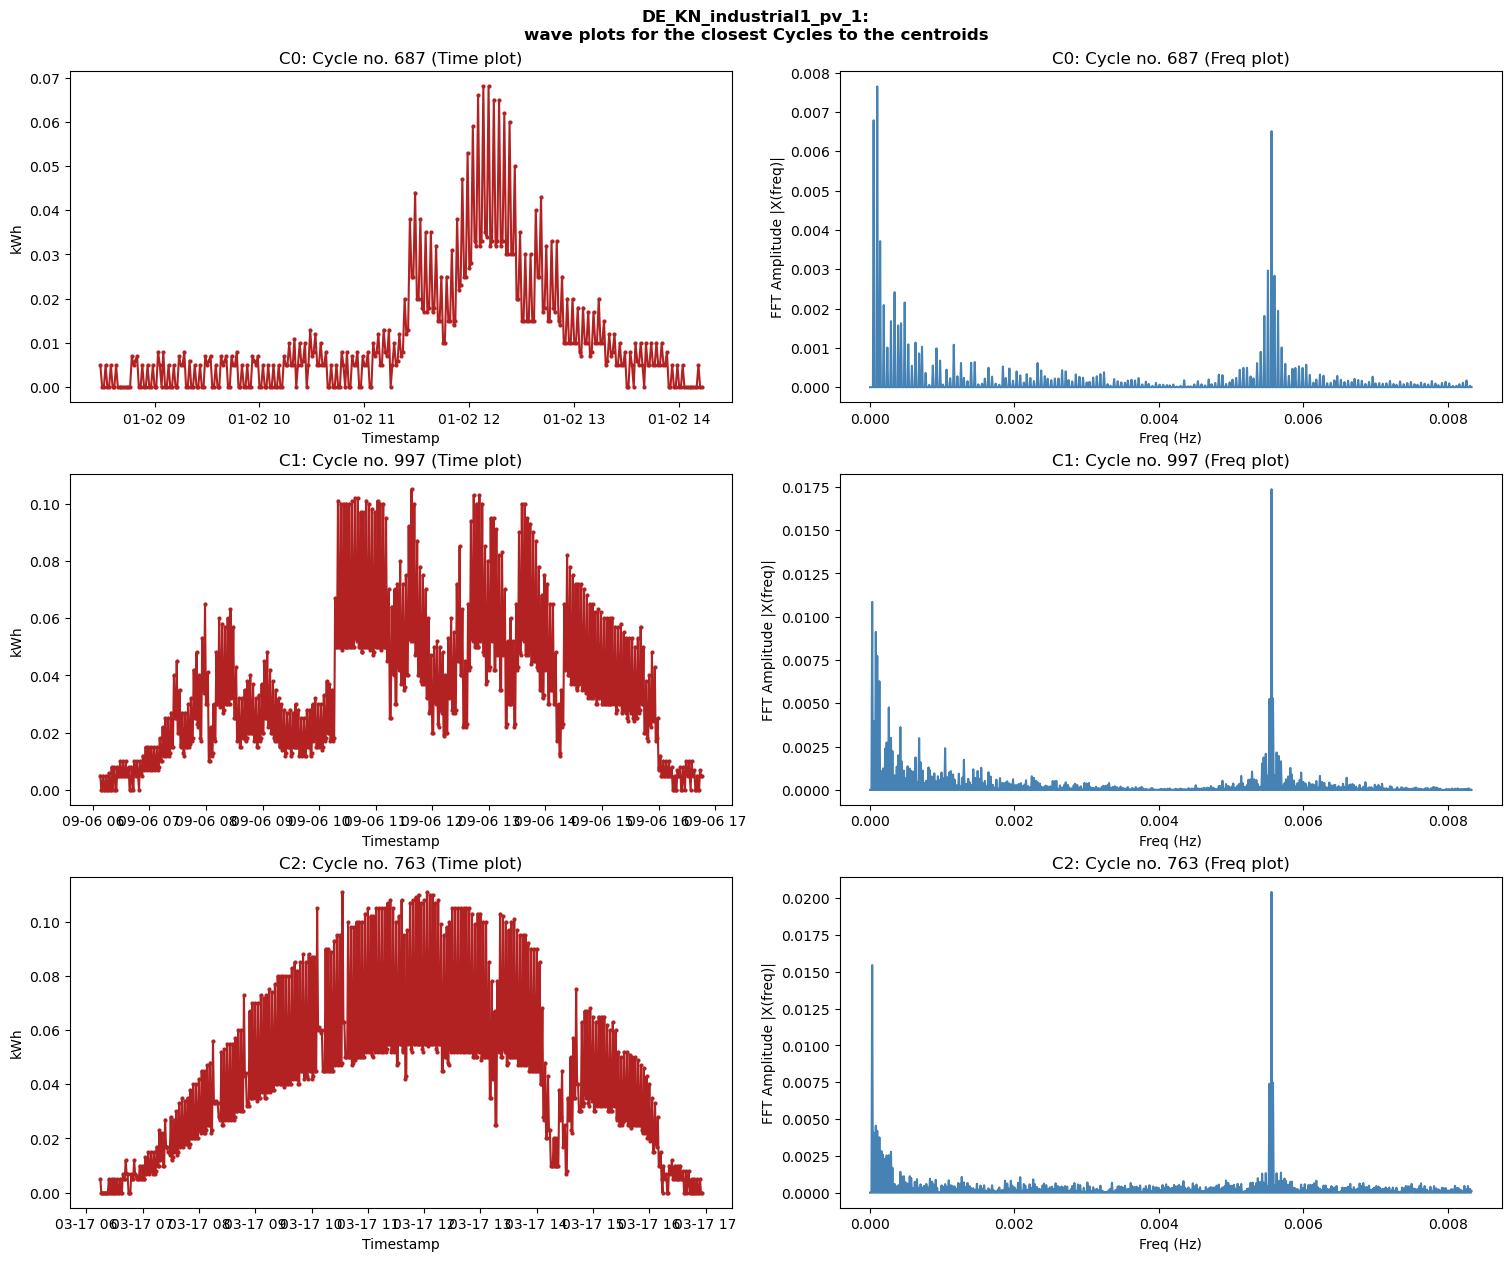

In [23]:
fig, subs = plt.subplots(K, 2, figsize=((720*2)/96, (400*K)/96), constrained_layout=True)
fig.suptitle(f"{FOCUS_DEVICE}:\nwave plots for the closest Cycles to the centroids", fontsize=12, fontweight='bold')
cycles = ActCycles['cycle_no'].unique().tolist()

for i in range(K):
    #Time plot:
    sub1 = subs[i, 0]
    cycle_no = cycles[closest[i]]
    Temp = ActCycles.loc[ActCycles['cycle_no'] == cycle_no]
    sub1.plot(Temp.index, Temp['value'], 'firebrick', linewidth=1.5, marker='o', markersize=2)
    sub1.set_title(f"C{i}: Cycle no. {cycle_no} (Time plot)")
    sub1.set_xlabel(f"Timestamp")
    sub1.set_ylabel("kWh")
    #set time format and the interval of ticks (every 30 minutes):
    if len(Temp.index) <= 300:
        labels = [ts for ts in Temp.index[::5]]
        sub1.set_xticks(labels)
        sub1.set_xticklabels(labels, rotation=45, ha='right')
        sub1.grid(axis="x",linestyle="--")
        xformatter = md.DateFormatter('%Y-%m-%d %H:%M')
        sub1.xaxis.set_major_formatter(xformatter)

    #Freq plot:
    sub2 = subs[i, 1]
    sub2.plot(FreqCycles.index, FreqCycles[int(cycle_no)], 'steelblue', linewidth=1.5)
    sub2.set_title(f"C{i}: Cycle no. {cycle_no} (Freq plot)")
    sub2.set_xlabel(f"Freq (Hz)")
    sub2.set_ylabel("FFT Amplitude |X(freq)|")

    i += 1

plt.show()

---
## CYCLES ANALYSIS & EXPORT

### Build Cycle features

In [24]:
CycleDets = pd.DataFrame({'start_time': ActCycles['start_time'].unique()})
CycleDets['cycle_no'] = cycles

#Cycle length:
Temp = ActCycles.groupby([ActCycles['start_time']]).count()
CycleDets['length_mins'] = Temp['value'].to_list()

#Total kWh:
Temp = ActCycles.groupby([ActCycles['cycle_no']]).sum()
CycleDets['tot_kWh'] = Temp['value'].to_list()

#Mean kWh:
Temp = ActCycles.groupby([ActCycles['cycle_no']]).mean()
CycleDets['mean_kWh'] = Temp['value'].to_list()

#Median kWh:
Temp = ActCycles.groupby([ActCycles['cycle_no']]).median()
CycleDets['median_kWh'] = Temp['value'].to_list()

#Max kWh:
Temp = ActCycles.groupby([ActCycles['cycle_no']]).max()
CycleDets['max_kWh'] = Temp['value'].to_list()
CycleDets['cycle_no'] = Temp.index.to_list()

#Max kWh:
Temp = ActCycles.groupby([ActCycles['cycle_no']]).max()
CycleDets['max_kWh'] = Temp['value'].to_list()

#Peak freq: in FreqCycles, get index (xf) of the max value (amplitude) for each column (cycle):
peaks = FreqCycles.reset_index().idxmax().to_list()[1:]
CycleDets['Peak_Freq_Hz'] = [FreqCycles.index[p] for p in peaks]

#Time difference between activations:
deltas_act_act = [0]
deltas_deact_act = [0]
ActCycles.reset_index(inplace=True)
for ind in ActCycles.index[1:]:
    if ActCycles['start_time'].loc[ind] != ActCycles['start_time'].loc[ind-1]:
        deltas_act_act.append((ActCycles['start_time'].loc[ind] - ActCycles['start_time'].loc[ind-1]).seconds/60)
        deltas_deact_act.append((ActCycles['start_time'].loc[ind] - ActCycles['end_time'].loc[ind-1]).seconds/60)

ActCycles.set_index('timestamp',drop=True,inplace=True)
CycleDets['FromLastAct_mins'] = deltas_act_act
CycleDets['FromLastDeact_mins'] = deltas_deact_act

print("Cycle details:")
CycleDets.head(10)

Cycle details:


,start_time,cycle_no,length_mins,tot_kWh,mean_kWh,median_kWh,max_kWh,Peak_Freq_Hz,FromLastAct_mins,FromLastDeact_mins
0,2015-10-24 06:46:00,1,525,10.765,0.020505,0.018,0.073,0.00556,0.0,0.0
1,2015-10-25 07:56:00,3,449,9.733,0.021677,0.020,0.073,0.00004,70.0,985.0
2,2015-10-26 08:59:00,5,383,4.373,0.011418,0.010,0.037,0.00004,63.0,1054.0
3,2015-10-27 08:02:00,6,413,4.213,0.010201,0.010,0.027,0.00004,1383.0,1000.0
4,2015-10-28 08:29:00,8,420,8.271,0.019693,0.020,0.082,0.00004,27.0,1054.0
5,2015-10-29 06:56:00,9,468,2.758,0.005893,0.005,0.030,0.00556,1347.0,927.0
6,2015-10-30 07:32:00,10,453,2.540,0.005607,0.005,0.023,0.00556,36.0,1008.0
7,2015-10-31 08:02:00,11,438,2.286,0.005219,0.005,0.013,0.00556,30.0,1017.0
8,2015-11-01 07:38:00,12,471,6.641,0.014100,0.012,0.057,0.00556,1416.0,978.0
9,2015-11-02 08:17:00,14,294,2.162,0.007354,0.007,0.020,0.00556,39.0,1008.0


### Export to CSV

In [25]:
if not os.path.isdir(f"{EXP}/{ASSET_TYPE}"):
    os.mkdir(f"{EXP}/{ASSET_TYPE}")

#export CycleDets:
CycleDets.to_csv(f"{EXP}/{ASSET_TYPE}/CycleDets_{FOCUSNAME}.csv", index=False)

#(TIME) export ActCycles:
ActCycles.to_csv(f"{EXP}/{ASSET_TYPE}/ActCycles_{FOCUSNAME}.csv")

#(FREQ) export FreqCycles:
FreqCycles.to_csv(f"{EXP}/{ASSET_TYPE}/FreqCycles_{FOCUSNAME}.csv")

---

## METRICS

### Cycle metrics

Frequency histograms:

['length_mins', 'tot_kWh', 'mean_kWh', 'median_kWh', 'max_kWh', 'Peak_Freq_Hz', 'FromLastAct_mins', 'FromLastDeact_mins']


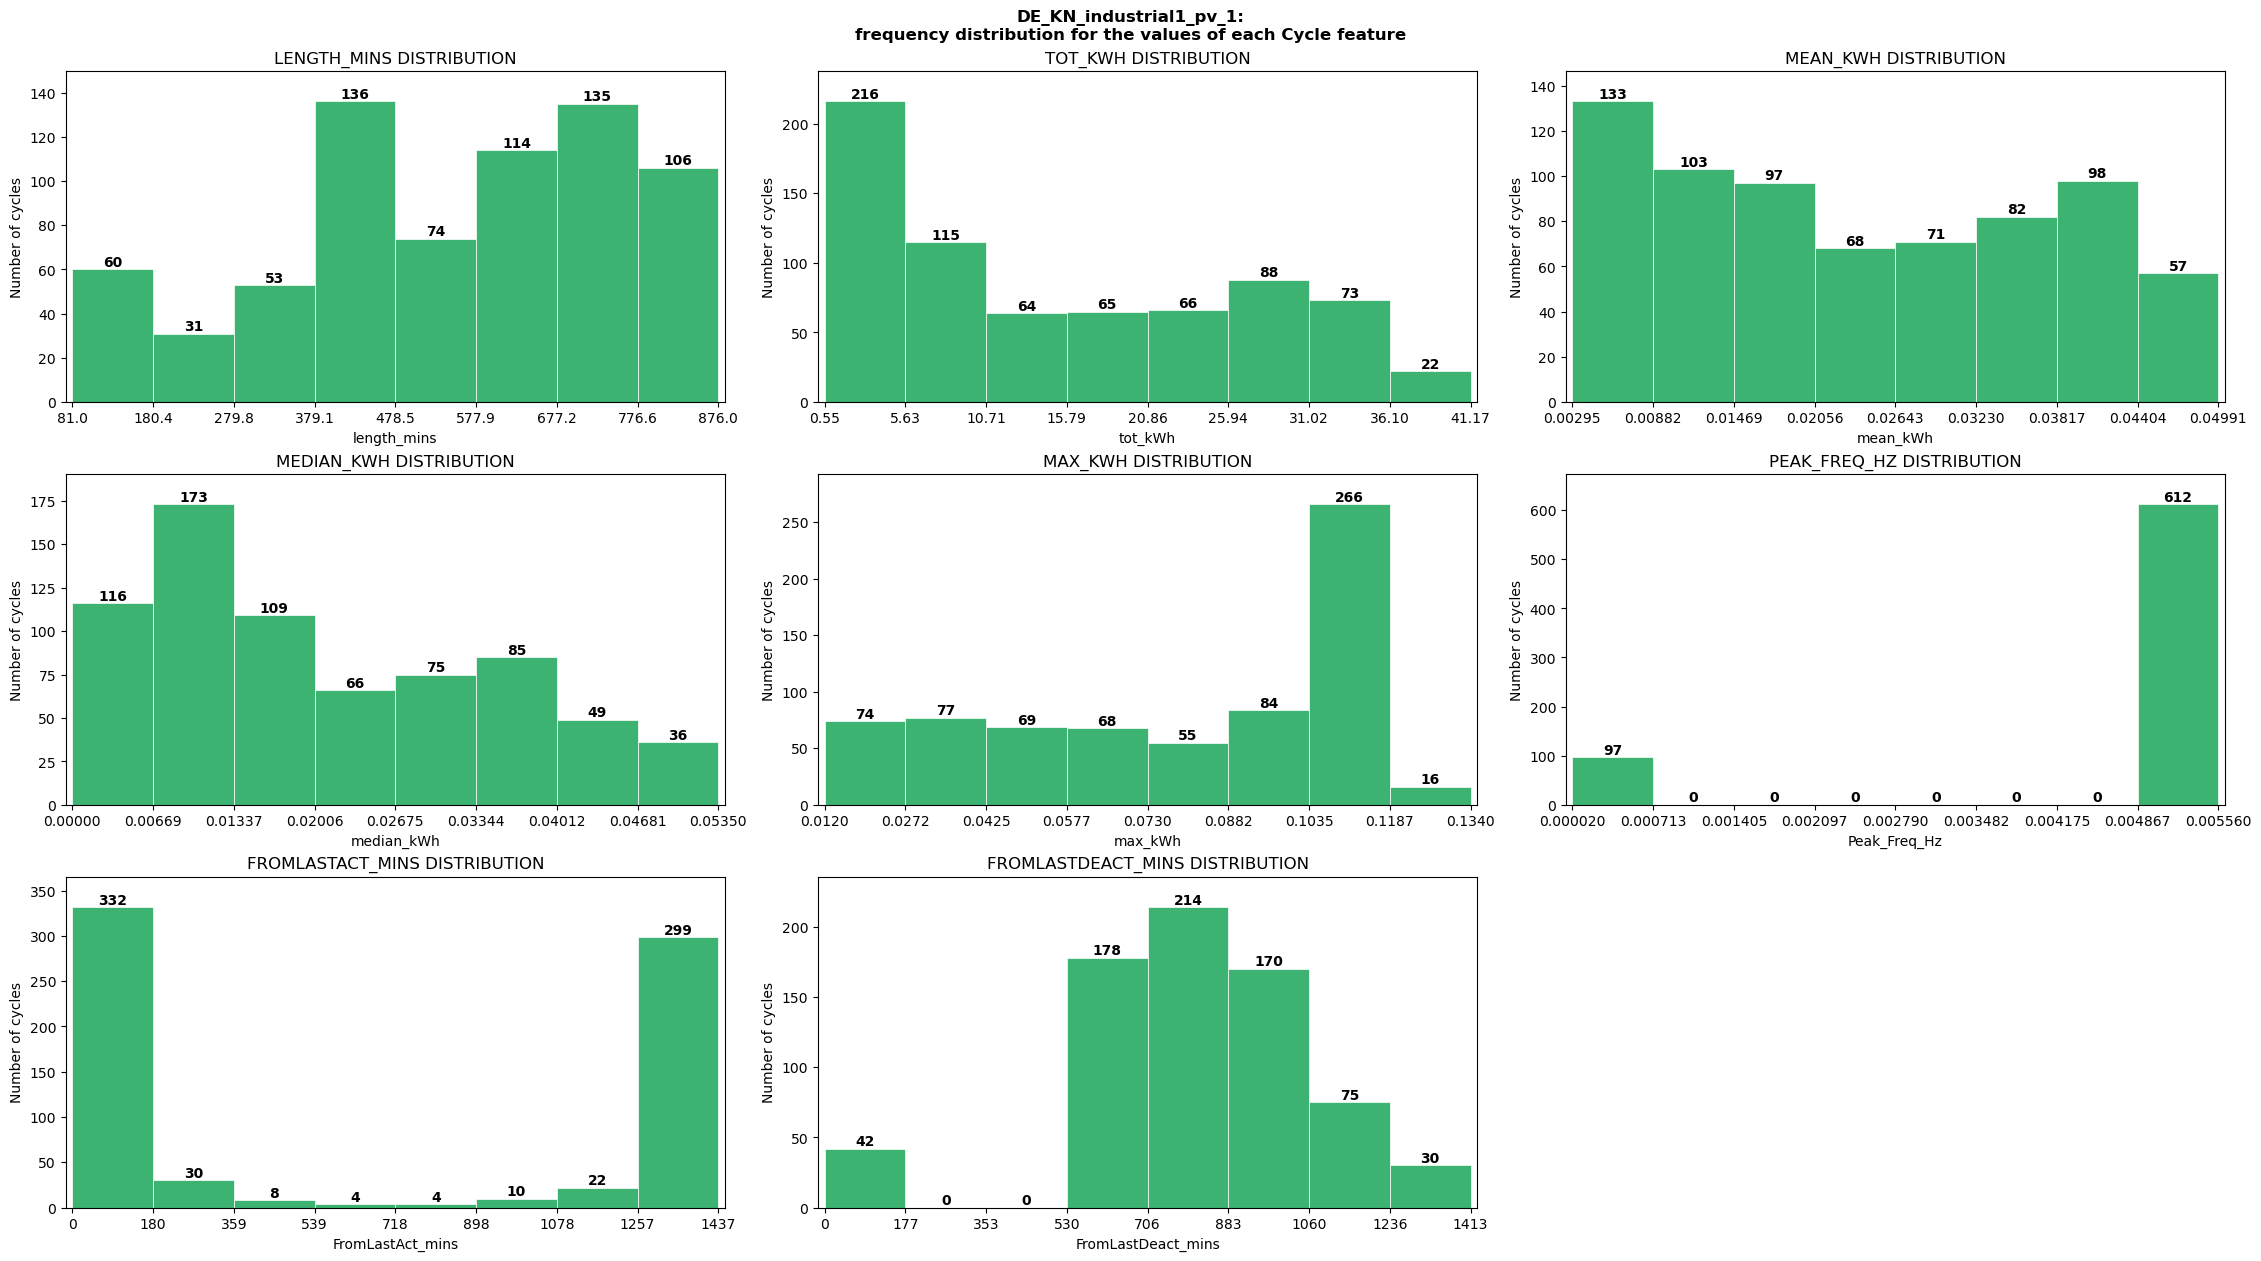

In [26]:
#plot:
COLS = list(CycleDets.columns)
COLS.remove('start_time')
COLS.remove('cycle_no')
print(COLS)
histograms = {}

fig, axes = plt.subplots(3, 3, figsize=((720*3)/96, (400*3)/96), constrained_layout=True)
fig.suptitle(f"{FOCUS_DEVICE}:\nfrequency distribution for the values of each Cycle feature", fontsize=12, fontweight='bold')
i = 0

for row in range(3):
    for col in range(3):
        if i >= len(COLS):
            fig.delaxes(axes[row, col])
        else:
            variable = COLS[i]
            ax = axes[row, col]
            cleaned = remove_outliers(CycleDets[variable], qmax=90)
            values, bins, bars = ax.hist(cleaned, bins=8, linewidth=0.5, color="mediumseagreen", edgecolor="white")
            ax.set_xticks(bins)
            ax.bar_label(bars, fontweight='bold')
            ax.set_title(f"{variable} distribution".upper())
            ax.set_xlabel(variable)
            ax.margins(x=0.01, y=0.1)
            ax.set_ylabel('Number of cycles')
            #accessible Hist:
            vars = [rect.get_x() for rect in bars.patches]
            histograms[variable] = {k: v for (k, v) in zip(vars, bars.datavalues)}
            i = i+1

plt.show()

### Pairwise comparisons

Calculate Pearson Correlation & Euclidean Distance between Cycle waves (interpolated, in freq domain):

In [27]:
#reduce number of cycles if calculations take too long:
if MAX_CYCLES_FOR_COMBOS > 0 and len(cycles) > MAX_CYCLES_FOR_COMBOS:
    combos = list(combinations(list(FreqWindows.columns)[:MAX_CYCLES_FOR_COMBOS], 2))
else:
    combos = list(combinations(FreqWindows.columns, 2))

#calculate pairwise comparisons:
Pairwise = pd.DataFrame(data={'combo': combos})
tot = len(Pairwise['combo'])
dists = []
corrs = []
i = 1

for combo in Pairwise['combo']:
    print(f"Current pair: {i}/{tot}", end="                 \r")
    a = FreqWindows[combo[0]]
    b = FreqWindows[combo[1]]
    corrs.append(np.corrcoef(a, b)[0][1])
    dists.append(np.linalg.norm(a-b))
    i += 1
    #break condition (if too many calculations):
    if MAX_PAIRS_NUM > 0 and i > MAX_PAIRS_NUM:
        print(f"\nStopped calculations after {i-1} pairs.")
        Pairwise = pd.DataFrame(data={'combo': combos[:MAX_PAIRS_NUM]})
        break

Pairwise['pcorr'] = corrs
Pairwise['pdist'] = dists
Pairwise.head(10)

,combo,pcorr,pdist
0,"(1, 3)",0.636677,0.022393
1,"(1, 5)",0.563146,0.025460
2,"(1, 6)",0.549963,0.028312
3,"(1, 8)",0.770380,0.024491
4,"(1, 9)",0.918563,0.022068
5,"(1, 10)",0.800471,0.028495
6,"(1, 11)",0.639263,0.031671
7,"(1, 12)",0.993974,0.012829
8,"(1, 14)",0.945248,0.026150
9,"(1, 15)",0.991348,0.023250


Frequency histograms:

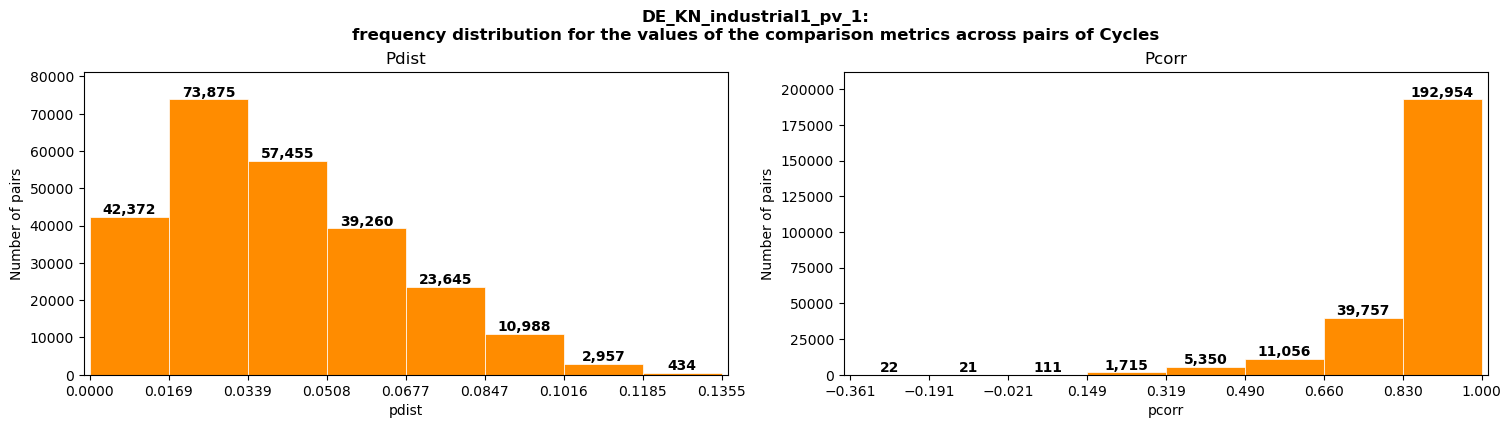

In [28]:
#plot:
vars = ['pdist', 'pcorr']
fig, axes = plt.subplots(1, len(vars), figsize=((720*len(vars))/96, 400/96), constrained_layout=True)
fig.suptitle(f"{FOCUS_DEVICE}:\nfrequency distribution for the values of the comparison metrics across pairs of Cycles", fontsize=12, fontweight='bold')
i = 0

for variable in vars:
    ax = axes[i]
    ax.set_title(variable.title())
    cleaned = remove_outliers(Pairwise[variable], qmax=90)
    values, bins, bars = ax.hist(cleaned, bins=8, color="darkorange", linewidth=0.5, edgecolor="white")
    ax.set_xticks(bins)
    ax.bar_label(bars, labels=[f"{int(b):,}" for b in bars.datavalues], fontweight='bold')
    ax.set_xlabel(variable)
    ax.margins(x=0.01, y=0.1)
    ax.set_ylabel('Number of pairs')

    #accessible Hist (top-3 only):
    vars = [rect.get_x() for rect in bars.patches]
    histograms[variable] = {k: v for (k, v) in zip(vars, bars.datavalues)}
    i += 1

plt.show()

### Metrics recap

Recap of the main characteristics of the waveform for the device analysed:

In [29]:
metrics = list(histograms.keys())
values_1 = []
freq_pct_1 = []
values_2 = []
freq_pct_2 = []
values_3 = []
freq_pct_3 = []

Recap = pd.DataFrame(data={
    'min_1': np.empty(len(metrics)),
    'max_1': np.empty(len(metrics)),
    'FREQ_%_1': np.empty(len(metrics)),
    'min_2': np.empty(len(metrics)),
    'max_2': np.empty(len(metrics)),
    'FREQ_%_2': np.empty(len(metrics)),
    'TOT_%_1+2': np.empty(len(metrics)),
    'min_3': np.empty(len(metrics)),
    'max_3': np.empty(len(metrics)),
    'FREQ_%_3': np.empty(len(metrics)),
    'TOT_%_1+2+3': np.empty(len(metrics)),
    }, index=metrics)

for variable in histograms:
    total = sum(histograms[variable].values())
    keys = list(histograms[variable].keys())
    width = abs(keys[1]-keys[0])
    #sort dict:
    temp = dict(sorted(histograms[variable].items(), key=lambda item: item[1], reverse=True))
    keys = list(temp.keys())
    values = list(temp.values())
    for i in range(3):
        Recap[f'min_{i+1}'].loc[variable] = round(keys[i],4) if variable.split('_')[-1] != 'mins' else f"{int(keys[i]):.0f}"
        Recap[f'max_{i+1}'].loc[variable] = round((keys[i]+width),4) if variable.split('_')[-1] != 'mins' else f"{int(keys[i]+width):.0f}"
        Recap[f'FREQ_%_{i+1}'].loc[variable] = round(values[i]/total*100,2)

Recap['TOT_%_1+2'] = Recap['FREQ_%_1'] + Recap['FREQ_%_2']
Recap['TOT_%_1+2+3'] = Recap['FREQ_%_1'] + Recap['FREQ_%_2'] + Recap['FREQ_%_3']

print("CYCLE ANALYSIS RECAP:")
Recap.style.apply(lambda x: ['background: dimgrey' if (x.name.split('_')[0] == 'TOT' or x.name.split('_')[0] == 'FREQ') else '' for i in x])

CYCLE ANALYSIS RECAP:


,min_1,max_1,FREQ_%_1,min_2,max_2,FREQ_%_2,TOT_%_1+2,min_3,max_3,FREQ_%_3,TOT_%_1+2+3
length_mins,379,478,19.180000,677,776,19.040000,38.220000,577,677,16.080000,54.300000
tot_kWh,0.552000,5.629700,30.470000,5.629700,10.707500,16.220000,46.690000,25.940800,31.018500,12.410000,59.100000
mean_kWh,0.002900,0.008800,18.760000,0.008800,0.014700,14.530000,33.290000,0.038200,0.044000,13.820000,47.110000
median_kWh,0.006700,0.013400,24.400000,0.000000,0.006700,16.360000,40.760000,0.013400,0.020100,15.370000,56.130000
max_kWh,0.103500,0.118700,37.520000,0.088200,0.103500,11.850000,49.370000,0.027200,0.042500,10.860000,60.230000
Peak_Freq_Hz,0.004900,0.005600,86.320000,0.000000,0.000700,13.680000,100.000000,0.000700,0.001400,0.000000,100.000000
FromLastAct_mins,0,179,46.830000,1257,1437,42.170000,89.000000,179,359,4.230000,93.230000
FromLastDeact_mins,706,883,30.180000,529,706,25.110000,55.290000,883,1059,23.980000,79.270000
pdist,0.016900,0.033900,29.430000,0.033900,0.050800,22.890000,52.320000,-0.000000,0.016900,16.880000,69.200000
pcorr,0.829900,1.000000,76.880000,0.659700,0.829900,15.840000,92.720000,0.489600,0.659700,4.410000,97.130000
